# **Deep Features Tracker++**

✅ Multiple Tracking

✅ Estimation Tracking

✅ Automated Analysis

✅ Deep Convolutional Features

✅ Centroid Based Tracking

❌ Lineage Mapper: Create a search radius for cell mitosis detection (use with features if features >= threshold and in the cell radius new cell is born. (maybe circularity/mean-intensity can also be looked at.))

❌ Cell Parser (Split the over segmented cells) 

### 🗒 TO-DO



*   regionprops_table ile regional propertieslerin hesaplanmasını hızlandır.
    

```
from skimage.measure import regionprops_table
props = regionprops(markers, intensity_image=img, 
                              properties=['label',
                                          'centroid',
                                          'area', 'equivalent_diameter',
                                          'mean_intensity', 'solidity'])
```


*   postprocess yöntemleri geliştir.


```
from skimage.segmentation import clear_border

img = cv2.imread(image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(mask.astype('uint8'), cv2.MORPH_OPEN,kernel, iterations = 2)
opening = clear_border(opening) 
sure_bg = cv2.dilate(opening,kernel,iterations=10)
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret2, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
ret3, markers = cv2.connectedComponents(sure_fg)
markers = markers
markers[unknown==255] = 0
markers = cv2.watershed(img.astype('uint8'), markers)
```


*   kalmanın predictionı olduğunda detectionsları update ederken bilgi yok ise None olarak gönder
*   

❗ Do not forget to restart the runtime.

In [ ]:
%%capture
!pip install lap
!pip install timm
!pip install -U kaleido
!pip install segmentation-models-pytorch
!pip install albumentations==0.4.6
!pip install pytorch-lightning==1.5.4

## Import Modules

In [ ]:
import torch
import torchvision.transforms as transforms
import timm
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import pandas as pd
from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment
import re
from skimage.measure import find_contours, label, regionprops
from skimage.transform import resize
from skimage.segmentation import clear_border
from scipy.ndimage.morphology import binary_fill_holes
import plotly.graph_objs as go
import plotly.offline as py
import imageio
import base64
from IPython import display
import warnings
warnings.filterwarnings("ignore")

### Utils

In [ ]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]

def get_file_dir(directory, get_dirs=True):
    """
    Creates a new folder or returns files 
    in the entered directory.
    Parameters
    ----------
    directory : string
        File path.
    get_dirs (bool, optional): Defaults to True.
        If true, it returns the path of all 
        files in the given directory.
    Returns
    ----------
    directories: list
        All files in the directory.
    """
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Failed to create file!')

    if get_dirs:
        for roots,dirs,files in os.walk(directory):               
            if files:
                directories = [roots + os.sep + file for file in  files]
                directories.sort(key=natural_keys)

        return directories

def random_color_generator(seed):
    """
    Code that generates random color according 
    to the seed given inside.

    Parameters
    ----------
    directory ([type]): [description]
    get_dirs (bool, optional): [description]. Defaults to True.
    Returns
    ----------
    color: tuple 
        Random generated RGB colors.
    """
    np.random.seed(seed)
    color = np.random.choice(range(255), size=3)
    return (int(color[0]), int(color[1]), int(color[2]))

def rgb2hex(color):
    """
    Converts RGB values in a variety of 
    formats to Hex values.
    Parameters
    ----------
    color : (list|tuple)
        The list or tuple of integers (e.g. (127, 127, 127))
    Returns
    ----------
    hex : str
        The rgb string.
    """
    return f"#{''.join(f'{hex(c)[2:].upper():0>2}' for c in color)}"

def make_gif(filenames, gif_dir, fx=0.3, fy=0.3):
    images = []
    for filename in filenames:
        images.append(cv2.resize(imageio.imread(filename), None, fx=fx, fy=fy))
    imageio.mimsave(gif_dir, images, format='GIF', **kwargs_write)

def show_gif(fname):
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/gdrive


## Feature Extractor

In [ ]:
# initialize the regnet parameters
mean_imagenet=[0.485, 0.456, 0.406]
std_imagenet=[0.229, 0.224, 0.225]
model_parameters={
        'vgg16':{
            'stage_depth': None,
            'stage_width': [64, 128, 256, 512, 512]
        },
        'nf_regnet_b0':{
            'stage_depth': None,
            'stage_width': [40, 40, 80, 160, 960]
        },
        'nf_regnet_b1':{
            'stage_depth': None,
            'stage_width': [40, 40, 80, 160, 960]
        },
        'nf_regnet_b2':{
            'stage_depth': None,
            'stage_width': [40, 40, 88, 176, 1064]
        },
        'nf_regnet_b3':{
            'stage_depth': None,
            'stage_width': [40, 40, 96, 184, 1152]
        },
        'nf_regnet_b4':{
            'stage_depth': None,
            'stage_width': [48, 48, 112, 216, 1344]
        },
        'nf_regnet_b5':{
            'stage_depth': None,
            'stage_width': [64, 64, 128, 256, 1536]
        },
        'regnetx_002':{
            'stage_depth': [1, 3, 6, 6],
            'stage_width': [32, 24, 56, 152, 368]
        },
        'regnetx_004':{
            'stage_depth': [2, 4, 10, 2],
            'stage_width': [32, 32, 64, 160, 384]
        },
        'regnetx_006':{
            'stage_depth': [1, 2, 7, 12],
            'stage_width': [32, 48, 96, 240, 528]
        },
        'regnetx_008':{
            'stage_depth': [2, 6, 17, 2],
            'stage_width': [32, 64, 128, 288, 672]
        },
        'regnetx_016':{
            'stage_depth': None,
            'stage_width': [32, 72, 168, 408, 912]
        },
        'regnetx_032':{
            'stage_depth': None,
            'stage_width': [32, 96, 192, 432, 1008]
        },
        'regnetx_040':{
            'stage_depth': None,
            'stage_width': [32, 80, 240, 560, 1360]
        },
        'regnetx_064':{
            'stage_depth': None,
            'stage_width': [32, 168, 392, 784, 1624]
        },
        'regnetx_080':{
            'stage_depth': None,
            'stage_width': [32, 80, 240, 720, 1920]
        },
        'regnetx_120':{
            'stage_depth': None,
            'stage_width': [32, 224, 448, 896, 2240]
        },
        'regnetx_160':{
            'stage_depth': None,
            'stage_width': [32, 256, 512, 896, 2048]
        },
        'regnetx_320':{
            'stage_depth': None,
            'stage_width': [32, 336, 672, 1344, 2520]
        },
        'regnety_002':{
            'stage_depth': [1, 3, 5, 7],
            'stage_width': [32, 24, 56, 152, 368]
        },
        'regnety_004':{
            'stage_depth': [1, 3, 6, 6],
            'stage_width': [32, 48, 104, 208, 440]
        },
        'regnety_006':{
            'stage_depth': [1, 3, 7, 4],
            'stage_width': [32, 48, 112, 256, 608]
        },
        'regnety_008':{
            'stage_depth': [2, 6, 17, 4],
            'stage_width': [32, 64, 128, 320, 768]
        },
        'regnety_016':{
            'stage_depth': None,
            'stage_width': [32, 48, 120, 336, 888]
        },
        'regnety_032':{
            'stage_depth': None,
            'stage_width': [32, 72, 216, 576, 1512]
        },
        'regnety_040':{
            'stage_depth': None,
            'stage_width': [32, 128, 192, 512, 1088]
        },
        'regnety_064':{
            'stage_depth': None,
            'stage_width': [32, 144, 288, 576, 1296]
        },
        'regnety_080':{
            'stage_depth': None,
            'stage_width': [32, 168, 448, 896, 2016]
        },
        'regnety_120':{
            'stage_depth': None,
            'stage_width': [32, 224, 448, 896, 2240]
        },
        'regnety_160':{
            'stage_depth': None,
            'stage_width': [32, 224, 448, 1232, 3024]
        },
        'regnety_320':{
            'stage_depth': None,
            'stage_width': [32, 232, 696, 1392, 3712]
        },
    }

In [ ]:
class FeatureExtractor(object):
    """
    The class required for feature inference.
    Parameters
    ----------
    extractor : string
        Model name to extract the features.
    Attributes
    ----------
    extractor : string
        Model name to extract the features.
    """ 
    def __init__(self, extractor='regnetx_008'):
        self.extractor = extractor
        if self.extractor not in model_parameters.keys():
                raise ValueError(
                    f"model_name should be in {model_parameters.keys()}," 
                    f"but got {self.extractor} instead.")
        else:
            self.model = timm.create_model(self.extractor, features_only=True, pretrained=True) 
            self._map = model_parameters[self.extractor]['stage_width']

        
    
    def get_crop(self, img, bbox):
        """
        Crop the image according to the given bounding box.
        Parameters
        ----------
        img : ndarray 
            Given image for crop.
        bbox : tuple
            Bounding box -> (x,y,w,h)
        Returns
        ----------
        crop : ndarray
            Cropped image.
        """
        x,y,w,h = bbox[1], bbox[0], bbox[3], bbox[2]
        crop = img[y:h, x:w]
        return crop

    def _get_features(self, img):
        """
        Extracts features through the 
        given image with the CNN model.
        Parameters
        ----------
        img : ndarray 
            Given image for feature extraction with FCN.
        Returns
        ----------
        feature : ndarray
            Image features from 3 different scales.
        """
        img = cv2.resize(img, (224, 224))
        normalize = transforms.Normalize(mean=mean_imagenet,
                                         std=std_imagenet) 
        transform_norm = transforms.Compose([
            normalize
        ])
        img = img.reshape(1, 3, img.shape[0], img.shape[1])
        img = torch.tensor(img, dtype=torch.float32)
        img = transform_norm(img)
        
        features = self.model(img)
        # flattening
        DX1 = np.reshape(features[2][0].detach().numpy(), [-1, self._map[2]])
        DX2 = np.reshape(features[3][0].detach().numpy(), [-1, self._map[3]])
        DX3 = np.reshape(features[4][0].detach().numpy(), [-1, self._map[4]])

        # normalization
        DX1 = DX1 / np.std(DX1)
        DX2 = DX2 / np.std(DX2)
        DX3 = DX3 / np.std(DX3)
        return np.asarray([DX1, DX2, DX3], dtype='object')

    def get_regionprops(self, img, mask):
        """
        Measure properties of labeled image regions.
        Parameters
        ----------
        img : ndarray 
            Given image.
        mask : ndarray
            Image to label.
        Returns
        ----------
        properties : dictionary
            centroid : array
                Centroid coordinate tuple (row, col).
            bbox : tuple
                Bounding box (min_row, min_col, max_row, max_col). 
                Pixels belonging to the bounding box are in the 
                half-open interval [min_row; max_row) 
                and [min_col; max_col).
            equivalent_diameter : float
                The diameter of a circle with the same area 
                as the region.
            perimeter : float
                Perimeter of object which approximates the contour 
                as a line through the centers of border pixels 
                using a 4-connectivity.
            eccentricity : float
                Eccentricity of the ellipse that has the same 
                second-moments as the region. The eccentricity 
                is the ratio of the focal distance 
                (distance between focal points) over the major 
                axis length. The value is in the interval [0, 1). 
                When it is 0, the ellipse becomes a circle.
            solidity : float
                Ratio of pixels in the region to pixels of the 
                convex hull image.
            area : float
                Area of the region i.e. number of pixels 
                of the region scaled by pixel-area. 
            mean_intensity : float
                Value with the mean intensity in the region.
            angle: float
                Angle between the 0th axis (rows) and the major 
                axis of the ellipse that has the same second 
                moments as the region, ranging from 
                -pi/2 to pi/2 counter-clockwise.
            contour : list of (n,2)-ndarrays
                Each contour is an ndarray of shape (n, 2), 
                consisting of n (x, y) coordinates along the contour.
        """
        labels = label(mask)
        props = regionprops(labels, img)

        contours = []
        for prop in props: 
            contour = find_contours(labels == prop.label, 0.5)[0]
            contour = np.array(contour).astype(np.int32)
            contour[:, 0], contour[:, 1] = contour[:, 1], contour[:, 0].copy()
            contours.append(np.array([contour]).astype(np.int32))

        return {
            'centroid':[prop.centroid for prop in props],
            'bbox':[prop.bbox for prop in props],
            'equivalent_diameter':[prop.equivalent_diameter for prop in props],
            'perimeter':[prop.perimeter for prop in props],
            'eccentricity':[prop.eccentricity for prop in props],
            'solidity':[prop.solidity for prop in props],
            'area':[prop.area for prop in props],
            'mean_intensity':[prop.mean_intensity for prop in props],
            'angle':[prop.orientation for prop in props],
            'contour':contours
        }

    def extract(self, img):
        """
        Performs feature extractions according to 
        the given constructor parameter.
        Parameters
        ----------
        img : ndarray 
            Gİven image for feature extractions.
        Returns
        ----------
        feature : ndarray
            Image features from 3 different scales.
        """
        return self._get_features(img)


## Detection

In [ ]:
class Detection(object):
    """
    This class represents a segmented detection.
    Parameters
    ----------
    centroid : array_like
        Segmented cell centroid.
    bbox : tuple
        Bounding box (min_row, min_col, max_row, max_col). 
        Pixels belonging to the bounding box are in the 
        half-open interval [min_row; max_row) and [min_col; max_col).
    feature : array_like
        A feature vector that describes the cell contained in this image.
    Attributes
    ----------
    centroid : ndarray
        Segmented cell centroid.
    bbox : tuple
        Bounding box (min_row, min_col, max_row, max_col). 
        Pixels belonging to the bounding box are in the 
        half-open interval [min_row; max_row) and [min_col; max_col).
    feature : ndarray | NoneType
        A feature vector that describes the cell contained in this image.
    """

    def __init__(self, centroid, bbox, feature, 
                 equivalent_diameter, perimeter, 
                 eccentricity, solidity, area, 
                 mean_intensity, angle, contour):
        self.centroid = centroid
        self.bbox = bbox
        self.feature = np.asarray(feature)
        self.equivalent_diameter = equivalent_diameter
        self.perimeter = perimeter
        self.eccentricity = eccentricity
        self.solidity = solidity
        self.area = area
        self.mean_intensity = mean_intensity
        self.angle = angle
        self.contour = contour


## Cost Matrix

In [ ]:
def cosine_distance(x, y):
    """
    Compute cosine distance between samples in x and y.
    Cosine distance, or the cosine kernel, computes distance as the
    normalized dot product of x and y: 
    K(X, Y) = 1 - (<X, Y> / (||X||*||Y||))
    Parameters
    ----------
    x : array_like
        Input array.
    y : array_like
        Input array.
    Returns
    ----------
    distance 
        The Cosine distance between vectors x and y.
    
    """
    dist = 0.0
    for x1, y1 in zip(x, y):
        X = np.hstack(x1)
        Y = np.hstack(y1)
        dist += distance.cosine(X, Y)
        
    return dist/len(x)

def euclidean_distance(x, y, normalize=True):
    """
    Compute the Euclidean distance between samples in x and y.
    Parameters
    ----------
    x : ndarray
        Input array.
    y : ndarray
        Input array.
    normalize : boolean
        If "True" normalize the data between 0 to 1.
    Returns
    ----------
    distance
        The Euclidean distance between vectors x and y.
    """
    def l2_normalize(v):
        norm = np.sqrt(np.sum(np.square(v)))
        return v / norm

    if normalize:
        x = l2_normalize(x)
        y = l2_normalize(y)

    return distance.euclidean(x, y)

def pairwise_distance(x, y):
    """
    Compute the pairwise distance between samples in x and y.
    Parameters
    ----------
    x : ndarray
        Input array.
    y : ndarray
        Input array.
    Returns
    ----------
    res
        The pairwise distance between vectors x and y.
    """
    assert len(x.shape) == len(y.shape)
    N = x.shape[0]
    M = y.shape[0]
    res = np.zeros([M, N])
    for i in range(M):
        for j in range(N):
            res[i][j] = np.linalg.norm(x[j] - y[i])

    return res

class Cost(object):
    """
    Is the class that calculates the cost matrix.
    Parameters
    ----------
    mu : float
        The weights for cost matrix. 
    Attributes
    ----------
    mu : float
        The weights for cost matrix.
    """
    def __init__(self, mu):
        self.mu = mu

    def _distance_matrix(self, tracks, detections):
        """Compute distance between tracks and detections.
        Parameters
        ----------
        tracks : ndarray
            An NxM matrix of N features of dimensionality M.
        detections : List[int]
            A list of detections.
        Returns
        -------
        ndarray
            Returns a cost matrix of shape len(tracks), len(detections), where
            element (i, j) contains the closest squared distance between
            `tracks[i]` and `detections[j]`.
        """
        cost_matrix = np.zeros((len(tracks), len(detections)))
        
        for i in range(len(tracks)):
            for j in range(len(detections)):
                cost_matrix[i][j] = self._metric(tracks[i], detections[j])

        return cost_matrix

    def cal_cost(self, tracks, detections):
        """Update the cost matrix with new data.
        Parameters
        ----------
        tracks : ndarray
            An NxM matrix of N features of dimensionality M.
        targets : ndarray
            An array of associated target identities.
        detections : List[int]
            A list of detections.
        Returns
        -------
        cost_matrix : ndarray
            Calculated new matrix.
        """
        self._metric = euclidean_distance
        Cd = self._distance_matrix([track.detection.centroid for track in tracks], 
        [detection.centroid for detection in detections])
        
        if self.mu == 1:
            cost_matrix = Cd
        else:
            self._metric = cosine_distance
            Cf = self._distance_matrix([track.detection.feature for track in tracks], 
            [detection.feature for detection in detections])
            
            cost_matrix = self.mu * Cd + (1 - self.mu) * Cf

        return cost_matrix


## Motion Model (Observer Model)

In [ ]:
class MotionModel(object):
    """
    This class includes are Kalman Filter.
    References: 
    https://en.wikipedia.org/wiki/Kalman_filter (basically Kalman)
    https://machinelearningspace.com/2d-object-tracking-using-kalman-filter/ (Python implementation)
    https://www.youtube.com/watch?v=HQW4wtLBddk (MATLAB implementation)
    http://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf (Kalman Algorithm)
    """
   
    def __init__(self):

        self.dt = 5e-3 # sampling time (time for 1 cycle)

        self.A = np.array([[1, 0], [0, 1]])  # matrix in observation equations
        self.u = np.zeros((2, 1))  # previous state vector, initial state

        self.b = np.array([[0], [255]])  # vector of observations /(x,y) centroid

        self.P = np.diag((3.0, 3.0))  # initial covariance matrix
        self.F = np.array([[1.0, self.dt], [0.0, 1.0]])  # state transition matrix

        self.Q = np.eye(self.u.shape[0])  # initial measurement noise covariance matrix
        self.R = np.eye(self.b.shape[0])  # observation noise matrix
        self.last_result = np.array([[0], [255]])

    def predict(self):
        """Predict function which predicst next state based on previous state.
            u: previous state vector, initial state
            P: previous covariance matrix
            F: state transition matrix
            Q: measurement noise covariance matrix

            u'_{k|k-1} = Fu'_{k-1|k-1}
            P_{k|k-1} = FP_{k-1|k-1} F.T + Q
        """

        self.u = np.round(np.dot(self.F, self.u))
        self.P = np.dot(self.F, np.dot(self.P, self.F.T)) + self.Q
        self.last_result = self.u  

        return self.u

    def correct(self, b, flag):
        """Correct function which correct the states based on measurements.
            u: previous state vector, initial state
            A: matrix in observation equations
            b: vector of observations
            P: predicted covariance matrix
            Q: measurement noise covariance matrix
            R: observation noise matrix
            
            C = AP_{k|k-1} A.T + R
            K_{k} = P_{k|k-1} A.T(C.Inv)
            u'_{k|k} = u'_{k|k-1} + K_{k}(b_{k} - Au'_{k|k-1})
            P_{k|k} = P_{k|k-1} - K_{k}(CK.T)
        """

        self.b = self.last_result if not flag  else b
            
        C = np.dot(self.A, np.dot(self.P, self.A.T)) + self.R
        K = np.dot(self.P, np.dot(self.A.T, np.linalg.inv(C))) 

        self.u = np.round(self.u + np.dot(K, (self.b - np.dot(self.A, self.u))))
        self.P = self.P - np.dot(K, np.dot(C, K.T))
        self.last_result = self.u

        return self.u



## Tracker

In [ ]:
class Tracker(object):
    """
    This is the multi-target tracker class.
    Parameters
    ----------
    dist_thresh : float
        The maximum distance a cell can move in a frame, in pixels.
    mu : float
        The weights for cost matrix (Default is 0.7).  
    max_frames_to_skip : int
        Maximum number of missed misses before a track is deleted.
    max_trace_length : int
        Maximum number of traces to keep.
    trackIdCounter : int
        A unique track identifier counter.
    Attributes
    ----------
    dist_thresh : float
        The maximum distance a cell can move in a frame, in pixels.
    max_frames_to_skip : int
        Maximum number of missed misses before a track is deleted.
    max_trace_length : int
        Maximum number of traces to keep.
    trackIdCounter : int
        A unique track identifier counter.
    tracks : List
        List of tracked cells.
    cost_matrix : Cost object
        Required object to calculate the cost matrix.
        metric='cosine' or 'euclidean', mu=0.7
    """
    def __init__(self, max_frames_to_skip=7, max_trace_length=20, 
                dist_thresh=0.7, mu = 0.7, trackIdCounter=0):
        self.dist_thresh = dist_thresh
        self.max_frames_to_skip = max_frames_to_skip
        self.max_trace_length = max_trace_length
        self.trackIdCounter = trackIdCounter
        self.tracks = []
        self.cost_matrix = Cost(mu=mu)  

    def update(self, detections):
        """
        Perform measurement update and track management.
        Parameters
        ----------
        detections : List[detection.Detection]
            A list of detections at the current time step.
        """
        if len(self.tracks) == 0: 
            self._initialize_track(detections)
        
        cost = self.cost_matrix.cal_cost(self.tracks, detections)
        
        assignment = self._nxm_match(cost, detections)

        for i in range(len(assignment)):
            self.tracks[i].KF.predict()

            if assignment[i] != -1:
                self.tracks[i].skipped_frames = 0
                self.tracks[i].prediction = self.tracks[i].KF.correct(detections[assignment[i]].centroid, 1)
                self.tracks[i].trace.append(detections[assignment[i]].centroid)
                self.tracks[i].detection = detections[assignment[i]]
            else:
                self.tracks[i].prediction = self.tracks[i].KF.correct(np.array([[0], [0]]), 0)

            if len(self.tracks[i].trace) > self.max_trace_length:
                for j in range(len(self.tracks[i].trace) - self.max_trace_length):
                    del self.tracks[i].trace[j]
            
            if self.tracks[i].skipped_frames < self.max_frames_to_skip and\
                self.tracks[i].skipped_frames != 0:
                if len(self.tracks[i].prediction) > 1:
                    self.tracks[i].trace.append(self.tracks[i].prediction[0])
                else:
                    self.tracks[i].trace.append(self.tracks[i].prediction)

            self.tracks[i].KF.last_result = self.tracks[i].prediction
      
    def _nxm_match(self, cost, detections):
        """
        It makes a unique assignment according to 
        the cost matrix it receives using Hungarian algorithm.
        Parameters
        ----------
        cost : ndarray
            N x M cost matrix for assignment.
        detections : List[detection.Detection]
            A list of detections at the current time step.
        Returns
        -------
        assignment : ndarray
            Unique ids assigned 1D array.
        """
        # Hungarian Algorithm
        assignment = np.asarray([-1]*len(self.tracks)) 
        row_ind, col_ind = linear_sum_assignment(cost) 
        assignment[row_ind] = col_ind 
        
        unmatched_tracks = [] 
        for i in range(len(assignment)):
            if assignment[i] != -1:
                if cost[i][assignment[i]] > self.dist_thresh: 
                    assignment[i] = -1
                    unmatched_tracks.append(i)
                pass
            else:
                self.tracks[i].skipped_frames += 1 
        
        del_tracks = [track.track_id for track in self.tracks \
        if track.skipped_frames > self.max_frames_to_skip]
        
        if del_tracks: 
            for id in del_tracks:
                if id < len(self.tracks):
                    del self.tracks[id]
                    assignment = np.delete(assignment, assignment[id])
                else:
                    pass

        unmatched_detections = [] 
        for i in range(len(detections)):
            if i not in assignment:
                unmatched_detections.append(detections[i])
        
        if unmatched_detections:
            self._initialize_track(unmatched_detections)
        
        return assignment

    def _initialize_track(self, detections):
        """
        Initialize the tracking for each detected cell.
        Parameters
        ----------
        detections : List[detection.Detection]
            A list of detections at the current time step.
        """
        for i in range(len(detections)):
            track = Track(detections[i], detections[i].centroid, self.trackIdCounter)
            self.trackIdCounter += 1
            self.tracks.append(track)



## Track

In [ ]:
class Track(object):
    """
    A single target track object, the traces of the 
    centroids have several properties such as the predicted centroids.
    Parameters
    ----------
    detection : Detection object
        Detected cell attribute.
    prediction : ndarray
        Centroid matrix of the initial state prediction.
    track_id : int
        A unique track identifier.
    Attributes
    ----------
    detection : Detection object
        Detected cell attribute.
    prediction : ndarray
        Estimated centroid from Kalman Filter.
    track_id : int
        A unique track identifier.
    KF : KalmanFilter object
        A Kalman filter to filter target trajectories in image space.
    skipped_frames : int
        The maximum number of frames to keep in 
        memory for cells leaving the field of view.
    trace : List
        List of traces.
    """
    def __init__(self, detection, prediction, trackIdCounter):
        self.detection = detection
        self.prediction = np.asarray(prediction) 
        self.track_id = trackIdCounter  
        self.KF = MotionModel()
        self.skipped_frames = 0  
        self.trace = []



## Segmentation Model

In [ ]:
class CFG:
    """
    Configuration class for cell segmentation.
    """
    seed                 = 101
    debug                = False # set debug=False for evaluation
    model_name           = 'FPN'
    backbone             = 'timm-regnetx_320'
    encoder_weights      = 'imagenet'
    pretrained_model_dir = '/content/gdrive/MyDrive/pretrained_models/FPN-timm-regnetx_320-imagenet-256x256-cell_motility.pth'
    img_size             = [256, 256]
    in_channels          = 3
    exp_name             = model_name + '-' + backbone + '-' + str(img_size[0]) + 'x' + str(img_size[1]) + '-' + 'cell_motility'
    train_bs             = 2
    valid_bs             = 4
    epochs               = 30
    lr                   = 1e-3
    scheduler            = 'CosineAnnealingLR'
    min_lr               = 1e-6
    T_max                = int(100*6*1.8)
    T_0                  = 25
    warmup_epochs        = 0
    wd                   = 1e-6
    n_accumulate         = 32//train_bs
    n_fold               = 5
    num_classes          = 1
    device               = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class SegmentationModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, 
                 encoder_weights, in_channels, 
                 out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, 
            encoder_name=encoder_name,
            encoder_weights=encoder_weights, 
            in_channels=in_channels, 
            classes=out_classes, 
            **kwargs
        )

        self.training = CFG.debug
        self.criterion = smp.losses.JaccardLoss(mode='binary')

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        """
        Sequentially pass `x` trough model`s 
        encoder, decoder and heads
        """
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        acc   = self.criterion(pred_mask, mask)

        return {
            "loss": loss,
            "acc": acc,
        }

    def shared_epoch_end(self, outputs, stage):

        metrics = {
            f"{stage}_per_image_iou": outputs[-1],
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(), 
            lr=CFG.lr, 
            weight_decay=CFG.wd
        )

    @torch.no_grad()
    def predict(self, x):
        """
        Inference method. Switch model to `eval` mode, 
        call `.forward(x)` with `torch.no_grad()`
        Args:
            x: 4D torch tensor with shape (batch_size, channels, height, width)
        Return:
            prediction: 4D torch tensor with shape (batch_size, classes, height, width)
        """
        prediction = self.forward(x)
        prediction = prediction.detach().numpy()
        prediction[:, :][prediction[:, :] >= .5] = 1
        prediction[:, :][prediction[:, :] < .5] = 0
        prediction = np.squeeze(prediction)

        return prediction

NameError: ignored

## DataLoader Model

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size),
        A.CLAHE(p=0.35),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=90, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, p=0.5),
        ToTensorV2()], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size),
        ToTensorV2()], p=1.0)
}

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 img_paths, 
                 mask_paths=None, 
                 transforms=None):
        """
        Run once when instantiating the Dataset object.
        """
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transforms = transforms
        
    def __len__(self):
        """
        Returns the number of samples in our dataset.
        Returns
        -------    
        num_datas : int    
            Number of datas.
        """
        return len(self.img_paths)
    
    def __getitem__(self, index):
        """
        Loads and returns a sample from the dataset at 
        the given index idx. Based on the index, it 
        identifies the image’s location on disk, 
        converts that to a tensor using read_image, 
        retrieves the corresponding label from the 
        ground truth data in self.mask_paths, calls the transform 
        functions on them (if applicable), and returns 
        the tensor image and corresponding label in a tuple.
        Returns
        -------   
        img, mask : torch.Tensor
            The transformed image and its corresponding 
            mask image. If the mask path is None, it 
            will only return the transformed image.
            output_shape_mask: (batch_size, 1, img_size, img_size)
            output_shape_img: (batch_size, 3, img_size, img_size)
        """
        img_path = self.img_paths[index]
        img = cv2.imread(img_path, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.mask_paths is not None:
            mask_path = self.mask_paths[index]
            mask = cv2.imread(mask_path, 0)
            mask[:, :][mask[:, :] > 1] = 1
            if self.transforms:
                data = self.transforms(
                    image=img, mask=mask
                )
                img  = data['image']
                mask = data['mask']
            mask = np.expand_dims(mask, axis=0) 
            return img, mask
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img = data['image']
            return img

##Deep Features Tracker

In [ ]:
class DeepFeaturesTracker(Tracker):
    """
    This is the multiple cell tracker class.
    Multiple Cell Tracking with Deep Convolutional Features.
    State-of-the-art Convolutional neural networks were used to
    infer deeply convolutional features. These features were used 
    to connect cells together in a time series. In addition, 
    various features and the distances of cells from each other 
    in 2D space are also used.
    Parameters
    ----------
    extractor : str
        Pretrained CNN models. (3 x H x W) All pre-trained models 
        expect input images normalized in the same way, i.e. mini-batches 
        of 3-channel RGB images of shape.
    dist_thresh : float
        The maximum distance a cell can move in a frame, in pixels.
    mu : float
        The weights for cost matrix (Default is 0.7).  
        If given as 1., convolutional features are not used.
    max_frames_to_skip : int
        Maximum number of missed misses before a track is deleted.
    max_trace_length : int
        Maximum number of traces to keep.
    """
    def __init__(self, extractor, 
                 max_frames_to_skip=7, 
                 max_trace_length=20, 
                 dist_thresh=0.7, mu = 0.7):
        super().__init__(max_frames_to_skip=7, 
                         max_trace_length=20, 
                         dist_thresh=0.7, mu = 0.7)
        
        self.extractor = extractor
        self.mu = mu
        
    def __call__(self, output_dir, path2images, path2masks=None, 
              masks_save_dir=None, save_results=True, verbose=False):
        return self.track(
            output_dir, 
            path2images, 
            path2masks, 
            masks_save_dir, 
            save_results, 
            verbose
        )
    

    def _init_tracks_data(self):
        """
        Initializes a dictionary to keep records 
        of tracked cells.
        """
        self.tracks_data = {
            'cell_id': [],
            'frame_id': [],
            'y': [], 'x': [],
            'equivalent_diameter': [],
            'perimeter': [],
            'eccentricity': [],
            'solidity': [],
            'area': [],
            'mean_intensity': [],
            'angle': []
        }

    def _update_tracks_data(self, tracker, frame, index):
        """
        Records the data of the tracked cells updated in each frame.
        """
        self.tracks_data['cell_id'].append(tracker.tracks[index].track_id)
        self.tracks_data['frame_id'].append(frame + 1)
        self.tracks_data['y'].append(tracker.tracks[index].detection.centroid[1])
        self.tracks_data['x'].append(tracker.tracks[index].detection.centroid[0])
        self.tracks_data['equivalent_diameter'].append(tracker.tracks[index].detection.equivalent_diameter)
        self.tracks_data['perimeter'].append(tracker.tracks[index].detection.perimeter)
        self.tracks_data['eccentricity'].append(tracker.tracks[index].detection.eccentricity)
        self.tracks_data['solidity'].append(tracker.tracks[index].detection.solidity)
        self.tracks_data['area'].append(tracker.tracks[index].detection.area)
        self.tracks_data['mean_intensity'].append(tracker.tracks[index].detection.mean_intensity)
        self.tracks_data['angle'].append(tracker.tracks[index].detection.angle)

    def _overlay_mask(self, img, mask, bbox, color, alpha=0.4):
        """
        Overlay the given mask to the image.
        Parameters
        ----------
        img : ndarray
            Raw image.
        mask : ndarray
            Binary segmented image.
        color : tuple
            RGB colors.
        alpha : float
            Transparency coefficient.
        Returns
        ----------
        img : ndarray
            Overlayed image.
        """
        x,y,w,h = bbox[1], bbox[0], bbox[3], bbox[2]
        for channel in range(img.shape[-1]):
            img[y:h, x:w, channel] = np.where(
                mask[y:h, x:w] == 255,
                img[y:h, x:w, channel] * (1 - alpha) + alpha * color[channel],
                img[y:h, x:w, channel]
            )
        return img

    def _expand_mask(self, mask, image_shape):
        """
        Resizes mini masks back to image size.
        Resize with bilinear interpolation.
        Parameters
        ----------
        img : ndarray
            Raw image.
        mask : ndarray
            Binary segmented image.
        Returns
        ----------
        expanded_mask : ndarray
            Resized binary segmented image.
        """
        expanded_mask = np.zeros(image_shape[:2] + (mask.shape[-1],), dtype=bool)
        for i in range(expanded_mask.shape[-1]):
            m = mask[:, :, i]
            m = resize(m, image_shape[:2])
            expanded_mask[:, :, i] = np.around(m).astype(np.bool)
        return expanded_mask

    def _detect_cells(self, images, masks_save_dir, file_type):
        """
        Segment cells and save the masks from 
        the given raw image path.
        Parameters
        ----------
        images : list
            A list with paths to raw images.
        masks_save_dir : str
            Path to save segmented images.
        file_type : str
            Format in which masks will be saved
        Returns
        ----------
        masks : list
            Binary segmented images paths.
        """
        model = SegmentationModel(
            CFG.model_name, 
            CFG.backbone,
            CFG.encoder_weights, 
            in_channels=CFG.in_channels, 
            out_classes=CFG.num_classes
        )
        model.load_state_dict(torch.load(CFG.pretrained_model_dir))
        
        get_file_dir(masks_save_dir, get_dirs=False)
        dataset = BuildDataset(images, transforms=data_transforms['valid'])
        for frame, image in enumerate(images):
            img = cv2.imread(image, 1)
            image_shape = (img.shape[1], img.shape[0])
            img = dataset.__getitem__(frame)
            pred = model.predict(img)
            mask = cv2.resize(pred, image_shape) 
            mask = np.around(mask).astype(np.bool) * 255
            cv2.imwrite(masks_save_dir + file_type % (frame + 1) + '_mask.png', mask)

        masks = get_file_dir(masks_save_dir)

        return masks

    def _postprocess_mask(self, mask):
        """
        Morphological operations for filled the holes 
        and other gaps.
        Parameters
        ----------
        mask : ndarray
            Given mask.
        Returns
        ----------
        mask : ndarray
            Postprocessed mask.
        """
        mask = binary_fill_holes(mask).astype(np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=10)
        mask = clear_border(mask)
        #mask = cv2.dilate(mask, kernel, iterations=10) 

        return mask

    def track(self, output_dir, path2images, path2masks=None, 
              masks_save_dir=None, save_results=True, verbose=False):
        """
        Track the multiple cells from given paths.
        Parameters
        ----------
        output_dir : str
            Enter a path to save frame-by-frame 
            visualizations of tracked cells.
        path2images : str
            It is the directory of the folder where 
            the raw images are located.
        path2masks : str, default=None
            It is the directory of the folder where 
            the masks are located.
        masks_save_dir : str, default=None
            Enter a path to save frame-by-frame 
            detected cells.
        save_results : bool, default=True
            Enter True to save the data of 
            the tracked cells as a CSV.
        """
        self._init_tracks_data()

        file_type =  "%#04d"
        alpha = 0.4 
        images = get_file_dir(path2images)
        if path2masks:
            masks = get_file_dir(path2masks)
        else:
            masks = self._detect_cells(images, masks_save_dir, file_type)
        get_file_dir(output_dir, get_dirs=False)
        
        extractor = FeatureExtractor(extractor=self.extractor)

        tracker = Tracker(dist_thresh=self.dist_thresh, 
                          max_frames_to_skip=self.max_frames_to_skip, 
                          max_trace_length=self.max_trace_length, 
                          mu=self.mu)
        
        for frame, ims in enumerate(zip(masks, images)):
            mask = cv2.imread(ims[0], 0)
            img = cv2.imread(ims[1], 1)
            
            mask = self._postprocess_mask(mask)

            props = extractor.get_regionprops(img, mask) 

            # self detections function
            detections = []
            for index in range(len(props['centroid'])):
                if self.mu == 1:
                    feature = None
                else:
                    crop = extractor.get_crop(img, props['bbox'][index])
                    feature = extractor.extract(crop)

                detections.append(Detection(
                    [props['centroid'][index][1], props['centroid'][index][0]], 
                    props['bbox'][index], 
                    feature,
                    props['equivalent_diameter'][index],
                    props['perimeter'][index], 
                    props['eccentricity'][index], 
                    props['solidity'][index], 
                    props['area'][index], 
                    props['mean_intensity'][index][0], 
                    props['angle'][index],
                    props['contour'][index]
                ))

            tracker.update(detections)
            for j in range(len(tracker.tracks)):
                if (len(tracker.tracks[j].trace) >= 1):
                    # self visualize function
                    x = int(tracker.tracks[j].trace[-1][0])
                    y = int(tracker.tracks[j].trace[-1][1])
                    tl = (x-20, y-20)
                    br = (x+20, y+20)
                    cv2.rectangle(img, tl, br, random_color_generator(j), 1)
                    cv2.putText(img, str(tracker.tracks[j].track_id), (x-20,y-30), 2, 2.5, random_color_generator(j), 2)
                    for k in range(len(tracker.tracks[j].trace)): 
                        x1 = int(tracker.tracks[j].trace[k][0])
                        y1 = int(tracker.tracks[j].trace[k][1])
                        cv2.circle(img,(x1,y1), 3, random_color_generator(j),-1)
                    cv2.circle(img, (x,y), 10, random_color_generator(j), -1)
                    
                    # for track results
                    self._update_tracks_data(tracker, frame, j)

                    """
                    # overlay masks
                    img = self._overlay_mask(
                        img, mask, 
                        tracker.tracks[j].detection.bbox, 
                        random_color_generator(j)
                    )
                    """
                    # overlay masks
                    img_masked = img.copy() 
                    cv2.drawContours(
                        img_masked, 
                        tracker.tracks[j].detection.contour, 
                        -1, random_color_generator(j), -1
                    )
                    cv2.addWeighted(img_masked, alpha, img, 1 - alpha, 0, img)

            cv2.imwrite(output_dir + file_type % (frame + 1) + '.png', img)

        if save_results:
            # Save the results...
            df_tracks = pd.DataFrame(self.tracks_data)
            df_tracks.to_csv('/content/tracks.csv', encoding='utf-8', index=False)

## Main

In [ ]:
# Paths
path2images = '/content/gdrive/MyDrive/Datas/cm_exp/exp3_ground_truths_images/images' 
output_dir = '.' + os.sep + 'temp' + os.sep 
path2masks = '/content/gdrive/MyDrive/Datas/cm_exp/exp3_ground_truths_images/masks'
#masks_save_dir = '/content/masks/' 

# Parameters
mu = 0.8
dist_thresh = 0.6
max_frames_to_skip = 7
max_trace_length = 20

tracker = DeepFeaturesTracker('vgg16',
                              dist_thresh=dist_thresh, 
                              max_frames_to_skip=max_frames_to_skip, 
                              max_trace_length=max_trace_length, 
                              mu=mu)

tracker(output_dir, path2images, path2masks)
#tracker(output_dir, path2images, masks_save_dir=masks_save_dir)

In [ ]:
!rm -r /content/temp

###GIF maker


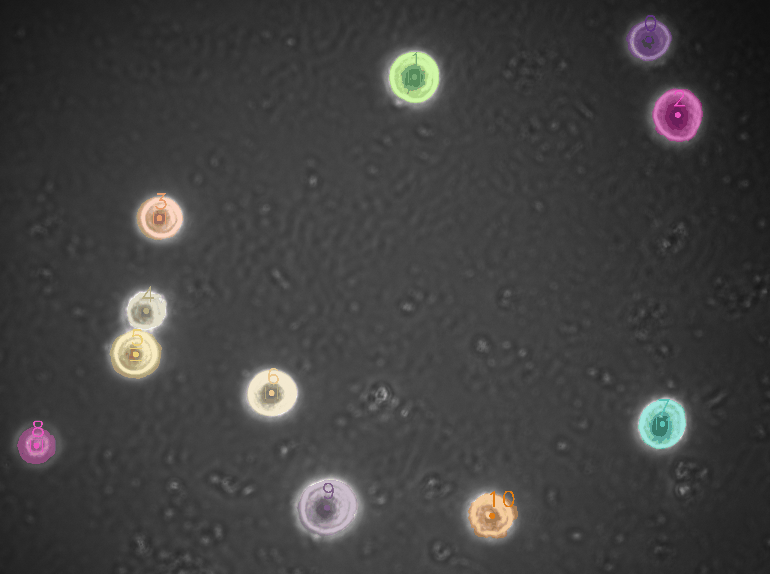

In [ ]:
filenames = get_file_dir('/content/temp')
kwargs_write = {'fps':5.0}
gif_dir = '/content/tracks.gif'

make_gif(filenames, gif_dir)
show_gif(gif_dir)

## Data Analysis

**step centric features**
1. instantaneous displacement of cell between adjacent time points 

$d_{i}=\sqrt{(x_{i}-x_{i-1})^2+(y_{i}-y_{i-1})^2}$

2. instantaneous speed between adjacent time points

$s_{i}=d(p_{i-1},p_{i})/\Delta t$

3. turning angle of each cell migration step

$\alpha_{i}=\tan^{-1}{\frac{(y_{i}-y_{i-1})}{(x_{i}-x_{i-1})}}$

4. Direction autocorrelation (persistence between adjacent steps)

$dir-aut_{i}=\cos{(\alpha_{i}-\alpha_{i-1})}$
    

**cell-centric features**
5. cumulative distance (total distance travelled)

$d_{total}=\sum\limits_{i=1}^{N} d(p_{i-1},p_{i})$

6. Euclidean distance (net trigonometric distance travelled)

$d_{net}=d(p_{0},p_{N})=\sqrt{(x_{N}-x_{0})^2+(y_{N}-y_{0})^2}$
    
7. net velocity 
    
$\bar{v}_{net}=\frac{d_{net}}{t_{elapsed}}$

8. end-point directionality ratio (confinement ratio, meandering index)

$ep\_dr = \frac{d_{net}}{d_{tot}}$
    
9. mean curvilinear speed

$\bar{v} = \frac{1}{N-1} \sum\limits_{i=1}^{N-1} v_{i}$
    
10.  Acircularity (inverse of circularity) 

$a=\frac{P^{2}}{4\pi A}$
    
11. Mean squared displacement

$MSD = \frac{1}{N-n} \sum\limits_{i=1}^{N-n} d^{2}(p_{i}, p_{i+n})$
    
12. Directedness

$Index_{directedness}=\sum\limits_{i=1}^{N} \frac{\cos{\Phi_{i}}}{N} = \sum\limits_{i=1}^{N} \frac{(x_{i}-x_{i-1})}{d_{i}\times N}=\frac{1}{N}\sum\limits_{i=1}^{N} \frac{(x_{i}-x_{i-1})}{\sqrt{(x_{i}-x_{i-1})^2+(y_{i}-y_{i-1})^2}}$

for a cell population moving directly toward positive x the directedness equals to +1; -1 for negative x. A group of cell undergoing random migration has a directedness of 0.

13. Orientation

$Index_{orientation}=\sum\limits_{i=1}^{N} \frac{\cos{2\theta_{i}}}{N}$
    
    for a cell aligning perpendicularly the orientation is -1, for a cell aligning parallely the oreintation is 1. for a group of cells aligning randomly the orientation is close to 0.


In [ ]:
df_tracks = pd.read_csv('/content/tracks.csv')
df_tracks

cell_id  frame_id            y            x  equivalent_diameter  \
0         0         1   277.045648  1584.447608           319.729776   
1         1         1   940.100276   962.755287           130.536450   
2         2         1  1088.607169  1913.385328           261.835031   
3         3         1  1299.173103   778.997473           163.424211   
4         4         1  1700.851527  1235.787033           172.428004   
5         5         1  1708.530685   397.803687           121.283702   
6         0         2   276.055447  1617.993537           378.444646   
7         1         2   948.337019   956.141089           286.726009   
8         2         2  1103.933531  1917.059373           338.336925   
9         3         2  1295.181038   798.932643           207.465329   
10        4         2  1721.979561  1219.798085           266.252058   
11        5         2  1771.962371   418.465549           140.812497   
12        0         3   274.910965  1684.395190           391.973327   
13        1         3   946.665952   919.660882           317.724405   
14        2         3  1085.585812  1955.985629           369.497230   
15        3         3  1284.525206   816.880320           234.162467   
16        4         3  1726.405223  1222.317561           342.362215   
17        5         3  1749.643488   395.941406           143.526104   
18        0         4   297.152997  1729.913197           378.676719   
19        1         4   963.042687   868.700346           308.510090   
20        2         4  1081.216993  1952.910554           353.243960   
21        3         4  1294.476178   833.403705           216.501826   
22        4         4  1714.863650  1216.594431           361.814037   
23        5         4  1756.248880   415.263498           143.068511   
24        0         5   392.083553  1697.147446           423.850217   
25        1         5   988.170441   836.306779           334.554433   
26        2         5  1085.518284  1958.469326           358.684387   
27        3         5  1305.243261   849.550818           229.898775   
28        4         5  1708.607314  1219.218622           379.606944   
29        5         5  1748.305807   405.493046           127.296974   
30        0         6   340.505938  1746.479282           377.471082   
31        1         6   965.032001   796.541448           307.919355   
32        2         6  1079.167970  2001.805632           357.450502   
33        3         6  1259.706725   892.748905           191.352614   
34        4         6  1697.890316  1201.456035           410.353201   
35        5         6  1756.190644   404.210198           136.943584   

      perimeter  eccentricity  solidity    area  mean_intensity     angle  
0   1700.587012      0.673621  0.876087   80289       63.064168  1.267039  
1    489.445743      0.447554  0.954361   13383      113.047299 -1.519123  
2   1473.449927      0.532669  0.823923   53845       76.667416  0.849578  
3    651.997041      0.560670  0.885287   20976       80.281465  0.679576  
4    762.582828      0.356748  0.914900   23351      101.015674  1.078307  
5    620.156421      0.629398  0.803128   11553       75.055830  1.016221  
6   2223.848989      0.667063  0.751001  112485       55.499960  1.375366  
7   1325.283405      0.453559  0.926890   64569       76.996175 -1.216548  
8   2692.851081      0.640487  0.710433   89906       65.551376  0.490658  
9   1048.028571      0.670475  0.847222   33805       79.219583  1.466434  
10  1232.371716      0.515804  0.941651   55677       79.035724 -0.632186  
11   573.043723      0.611220  0.916922   15573       87.994734  0.984142  
12  2225.665222      0.626699  0.761077  120671       50.050518 -0.124688  
13  1577.616449      0.668374  0.875768   79285       68.037712 -0.988408  
14  3384.237949      0.480442  0.587775  107229       57.419411  0.608996  
15  1298.437734      0.694886  0.761458   43065       71.658586  1.286239  
16  1565.834703      0.523164  0.912152   92058

In [ ]:
get_file_dir('/content/track_results/', False)
t_delta=60 # time between frames (in minutes)
download=False

In [ ]:
frames = df_tracks['frame_id'].unique()
fig = go.Figure()
for frame in frames:
    fig.add_trace(go.Box(
        y=df_tracks[df_tracks['frame_id']==frame]['area'].values,
        name = str(frame),
        marker_color='dodgerblue',
        boxpoints='all',
        boxmean='sd',
        jitter=0.5,
        whiskerwidth=0.9,
        marker_size=2,
        line_width=1
    ))

fig.update_layout(
    title_text='Cell Area Change by Time',
    showlegend=False,
    title_font_size=30,
    yaxis=dict(
        title="Cell Area",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Time (Frame)",
        autorange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    width=670,
    height=470,
    font=dict(
        size=20
    ))
fig.show()
fig.write_image("/content/track_results/cell_area.png", format='png', scale=2)

In [ ]:
cell_ids = df_tracks['cell_id'].unique()
to_frames = [str(frames[j]) + " to -> " + str(frames[j+1]) for j in range(len(frames)-1)]
all_cell_displacement = []
for cell_id in cell_ids:
    cell_displacement = []
    for frame in frames[2::]:
        x0 = df_tracks[(df_tracks['frame_id']==frame-1) & (df_tracks['cell_id']==cell_id)]['x'].values[0]
        y0 = df_tracks[(df_tracks['frame_id']==frame-1) & (df_tracks['cell_id']==cell_id)]['y'].values[0]

        xn = df_tracks[(df_tracks['frame_id']==frame) & (df_tracks['cell_id']==cell_id)]['x'].values[0]
        yn = df_tracks[(df_tracks['frame_id']==frame) & (df_tracks['cell_id']==cell_id)]['y'].values[0]

        cell_displacement.append(euclidean_distance([x0, y0], [xn, yn], normalize=False))

    all_cell_displacement.append(cell_displacement)

fig = go.Figure()
for index, displacement in enumerate(all_cell_displacement):
    fig.add_trace(go.Scatter(x=to_frames, 
                             y=displacement,
                             name='cell-' + str(index),
                             line=dict(width=3),
                             marker_color='rgb'+str(random_color_generator(index))))

fig.update_layout(
    title='Time-dependent Displacement',
    title_font_size=30,
    yaxis_title="Distance (px)",
    xaxis_title="Time (Frame)",
    width=670,
    font=dict(
        size=20
    ))

fig.show()
fig.write_image("/content/track_results/displacement.png", format='png', scale=2)

In [ ]:
normalized_cell_areas = []
for cell_id in cell_ids:
    normalized_cell_area = []
    for frame in frames:
        area_first_frame = df_tracks[(df_tracks['frame_id']==1) & (df_tracks['cell_id']==cell_id)]['area'].values[0]
        area = df_tracks[(df_tracks['frame_id']==frame) & (df_tracks['cell_id']==cell_id)]['area'].values[0]
        normalized_cell_area.append(area/area_first_frame)
    normalized_cell_areas.append(normalized_cell_area)

fig = go.Figure()
for index, areas in enumerate(normalized_cell_areas):
    fig.add_trace(go.Scatter(x=np.linspace(0, len(frames) * t_delta, len(frames)), 
                             y=areas,
                             name='cell-' + str(index),
                             line=dict(width=3),
                             marker_color='rgb'+str(random_color_generator(index))))

fig.update_layout(
    title='Normalized Cell Area',
    title_font_size=30,
    yaxis_title="Normalized Area",
    xaxis_title="Time (minutes)",
    width=670,
    font=dict(
        size=20
    ))

fig.show()
fig.write_image("/content/track_results/normalized_cell_area.png", format='png', scale=2)

In [ ]:
fig = go.Figure()
for frame in frames:
    fig.add_trace(go.Box(
        y=np.cos(df_tracks[df_tracks['frame_id']==frame]['angle'].values),
        name = str(frame),
        marker_color='dodgerblue',
        boxpoints='all',
        boxmean='sd',
        jitter=0.5,
        whiskerwidth=0.9,
        marker_size=2,
        line_width=1
    ))

fig.update_layout(
    title_text='Oriantation Angle Change by Time',
    showlegend=False,
    title_font_size=30,
    yaxis=dict(
        title="Oriantation Angle (degrees)",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Time (Frame)",
        autorange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    width=670,
    height=470,
    font=dict(
        size=20
    ))
fig.show()
fig.write_image("/content/track_results/oriantation.png", format='png', scale=2)

In [ ]:
fig = go.Figure()
for frame in frames:
    fig.add_trace(go.Box(
        y=df_tracks[df_tracks['frame_id']==frame]['perimeter'].values,
        name = str(frame),
        marker_color='dodgerblue',
        boxpoints='all',
        boxmean='sd',
        jitter=0.5,
        whiskerwidth=0.9,
        marker_size=2,
        line_width=1
    ))

fig.update_layout(
    title_text='Cell Perimeter Change by Time',
    showlegend=False,
    title_font_size=30,
    yaxis=dict(
        title="Cell Perimeter (px)",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Time (Frame)",
        autorange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    width=670,
    height=470,
    font=dict(
        size=20
    ))
fig.show()
fig.write_image("/content/track_results/perimeter.png", format='png', scale=2)

In [ ]:
fig = go.Figure()
for frame in frames:
    fig.add_trace(go.Box(
        y=1-df_tracks[df_tracks['frame_id']==frame]['eccentricity'].values,
        name = str(frame),
        marker_color='dodgerblue',
        boxpoints='all',
        boxmean='sd',
        jitter=0.5,
        whiskerwidth=0.9,
        marker_size=2,
        line_width=1
    ))

fig.update_layout(
    title_text='Circularity Change by Time',
    showlegend=False,
    title_font_size=30,
    yaxis=dict(
        title="Circularity (a.u.)",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Time (Frame)",
        autorange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    width=670,
    height=470,
    font=dict(
        size=20
    ))
fig.show()
fig.write_image("/content/track_results/circularity_avg.png", format='png', scale=2)

In [ ]:
fig = go.Figure()
for cell_id in cell_ids:
    fig.add_trace(go.Scatter(x=np.linspace(0, len(frames) * t_delta, len(frames)), 
                             y=1-df_tracks[df_tracks['cell_id']==cell_id]['eccentricity'].values,
                             name='cell-' + str(cell_id),
                             line=dict(width=3),
                             marker_color='rgb'+str(random_color_generator(cell_id))))

fig.update_layout(
    title='Circularity Change by Time',
    title_font_size=30,
    yaxis_title="Circularity",
    xaxis_title="Time (minutes)",
    width=670,
    font=dict(
        size=20
    ))

fig.show()
fig.write_image("/content/track_results/circularity.png", format='png', scale=2)

In [ ]:
all_cell_speed = []
for cell_id in cell_ids:
    cell_speed = []
    for frame in frames[2::]:
        x0 = df_tracks[(df_tracks['frame_id']==frame-1) & (df_tracks['cell_id']==cell_id)]['x'].values[0]
        y0 = df_tracks[(df_tracks['frame_id']==frame-1) & (df_tracks['cell_id']==cell_id)]['y'].values[0]

        xn = df_tracks[(df_tracks['frame_id']==frame) & (df_tracks['cell_id']==cell_id)]['x'].values[0]
        yn = df_tracks[(df_tracks['frame_id']==frame) & (df_tracks['cell_id']==cell_id)]['y'].values[0]

        cell_speed.append(
            euclidean_distance([x0, y0], [xn, yn], normalize=False)/(frame*10/60)
        )

    all_cell_speed.append(cell_speed)

fig = go.Figure()
for index, speed in enumerate(all_cell_speed):
    fig.add_trace(go.Scatter(x=to_frames, 
                             y=speed,
                             name='cell-' + str(index),
                             line=dict(width=3),
                             marker_color='rgb'+str(random_color_generator(index))))

fig.update_layout(
    title='Cell Speeds',
    title_font_size=30,
    yaxis_title="Speed (px/h)",
    xaxis_title="Time (Frame)",
    width=670,
    font=dict(
        size=20
    ))

fig.show()
fig.write_image("/content/track_results/cell_speeds.png", format='png', scale=2)

In [ ]:
fig = go.Figure()
for cell_id in cell_ids:
    x = df_tracks[df_tracks['cell_id']==cell_id]['x'].values
    y = df_tracks[df_tracks['cell_id']==cell_id]['y'].values

    fig.add_trace(go.Scatter(x=x, 
                             y=y,
                             name='cell-' + str(cell_id),
                             mode="lines",
                             line=dict(width=3),
                             marker_color='rgb'+str(random_color_generator(cell_id))))
    
fig.update_layout(
    title_font_size=30,
    yaxis_title="Y position (px)",
    xaxis_title="X position (px)",
    width=670,
    font=dict(
        size=20
    ))

fig.show()
fig.write_image("/content/track_results/2d_hairball.png", format='png', scale=2)

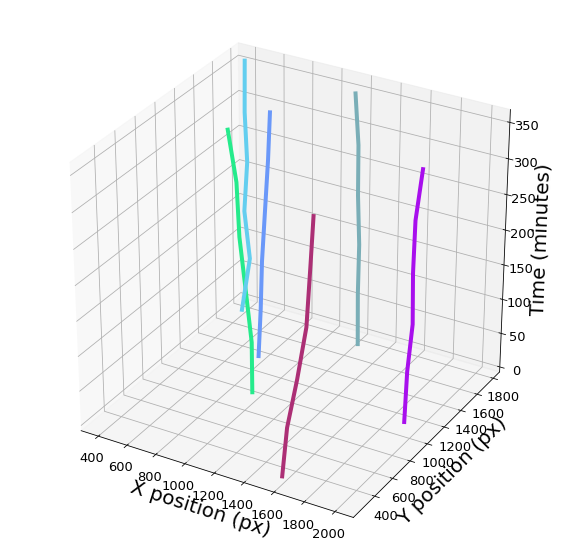

In [ ]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
       
for cell_id in cell_ids:
    x = df_tracks[df_tracks['cell_id']==cell_id]['x'].values
    y = df_tracks[df_tracks['cell_id']==cell_id]['y'].values
    t = np.linspace(0, len(frames) * t_delta, len(frames))

    ax.plot(x, y, t, rgb2hex(random_color_generator(cell_id)), linewidth=4)
    ax.set_xlabel('X position (px)', fontsize=20)
    ax.set_ylabel('Y position (px)', fontsize=20)
    ax.set_zlabel('Time (minutes)', fontsize=20)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 13)

plt.savefig('/content/track_results/3d_hairball.png', format='png', dpi=600)    
plt.show()

In [ ]:
!zip -r /content/track_results.zip /content/track_results/ /content/temp/

In [ ]:
from google.colab import files

if download:
    files.download("/content/track_results.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Requirements

In [ ]:
!pip list

Package                       Version
----------------------------- ---------------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.4
branca                        0.4.2
bs4                           0.0.1
CacheC